# Sklearn Circles with neuroevolution

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_circles

## Initialize the dataset

We create the circles dataset. Thhe circles dataset creates nested circles, and the model has to learn to predict which circle a given point belongs to.

In the dataset below, we have 2 circles, a yellow circle nested inside a purple circle.

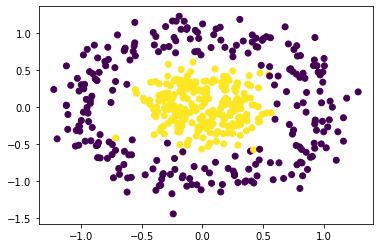

In [4]:
X, Y = make_circles(noise=0.15, factor=0.3, random_state=1, n_samples=500) # 500 samples
plt.scatter(X[:,0], X[:,1], c=Y)

Our goal is to classify the circles in the dataset. Given a dot at coordinates (X, Y), we classify it as either yellow or purple. To do this, we will be creating a neural network in PyTorch and training it using evolution strategies.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.36, random_state=42)
X_train, X_test, y_train, y_test = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.LongTensor(y_train), torch.LongTensor(y_test)

We split the dataset into a training and testing set. After that, we convert the numpy arrays to PyTorch tensors. This is so that we can pass these tensors to our neural network.

In [7]:
n_input_dim = X_train.shape[1]
n_input_dim

2

## Define the model

Our neural network will be a simple feedforward neural network with a sigmoid activation at the end.

In [8]:
model = nn.Sequential(
    nn.Linear(n_input_dim, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 2), 
    nn.Sigmoid()
)

### Loss function
Our loss function is normal Cross Entropy Loss, but because we are evolving the neural network to maximize rewards, we have to take the reciprocal of the loss function, so that increasing loss means the model is getting better.

In [9]:
loss_func = nn.CrossEntropyLoss()
def loss(y_pred, y_true):
    return 1/loss_func(y_pred, y_true)

We will define our fitness function down below. Our fitness function takes in a solution and evaluates the solutions.

Our solutions are a set a parameters for the neural network. Rather than defining a intiial population of neural networks, we will just define a population of model parameters.

In [10]:
def fitness_func(solution):
    nn.utils.vector_to_parameters(solution, model.parameters())
    return loss(model(X_train), y_train) + 0.00000001

The next function calculates the fitness of the population. The above function only calculated the fitness of one solution. This function will calculate the fitness of all solutions in the population.

In [11]:
def calc_population_fitness(pop):
    fitness = torch.zeros(pop.shape[0])
    for i, state_dict in enumerate(pop):
        fitness[i] = fitness_func(state_dict)
    return fitness

Now, we select the best solutions from the population in the `select_best_parents` function. This will be our mating pool.

In [12]:
def select_best_parents(pop, num_parents, fitness):
    parents = torch.zeros(num_parents, pop.shape[1])
    topk_fitness =  torch.topk(fitness, num_parents).indices
    for i, parent_n in enumerate(topk_fitness):
        parents[i] = pop[parent_n]
    return parents

In the previous function, we selected the best parents. `mate` will now make those parents mate and produce offspring. The offspring will have half of parent1's genes and half of parent2's genes. There are different ways to make offspring, we will use a single point crossover

In [13]:
def mate(parents, offspring_size):
    offspring = torch.zeros(offspring_size)
    crossover_point = np.random.randint(0, offspring_size[1], size=1)[0]
    for k in range(offspring_size[0]):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In order for our algorithm to evolve, we have to slightly mutate the offspring. Here, we use a random mutation function to slightly change the offspring. This will ensure that we get diversity in our population. And note that we only mutate a part of the genes, not all of them.

In [14]:
def mutate(offspring, percent_mutate=0.3):
    for k in range(offspring.shape[0]):
#         rand_param = np.random.randint(0, offspring.shape[1], size=1)
        indices = torch.from_numpy(np.random.choice(offspring.shape[1], int(offspring.shape[1]*percent_mutate), replace=False))
        offspring[k, indices] += torch.zeros(indices.shape[0]).uniform_(-2, 2)

This is a quick utility function to test a solution on the test set.

In [15]:
def test(best_solution):
    nn.utils.vector_to_parameters(best_solution, model.parameters())
    preds = model(X_test)
    _, preds_classes = torch.max(preds, 1)
    return (((preds_classes == y_test).sum())/len(y_test)).item()

Our model is a small model, it only has 982 parameters. Evolving this model should be very quick

In [16]:
params_shape = nn.utils.parameters_to_vector(model.parameters()).shape
params_shape

torch.Size([982])

We will have a initial population of 40 models. We will train this for 400 generations, and we take the top 6 models as our mating pool

In [17]:
POPULATION_SIZE = 40
NUM_GENERATIONS = 400
NUM_PARENTS=6

In [18]:
initial_population = nn.init.uniform_(torch.empty(POPULATION_SIZE, *params_shape))

In [19]:
best_solutions = []

Now, we combine all the above functions to train our model. Here is a step by step explanation of the process.

1. Calculate the fitness of the population
2. Select the mating pool using the `select_best_parents` function
3. Mate the parents to produce offspring. Our offspring size will be `population_size - parents_size`. So that way, when we create our new population of parents and offspring, our pool will always the same size as our initial population
4. Mutate the offspring with the `mutate` function
5. Create a new population with the parents and the offspring, after all, parents dont just die after creating offspring.
6. Repeat steps 1-5 for 400 generations

In [20]:
population = initial_population
for generation in range(1, NUM_GENERATIONS + 1):
    fitness = calc_population_fitness(population)
    best_parents = select_best_parents(population, NUM_PARENTS, fitness)
    offspring = mate(best_parents, (initial_population.shape[0] - best_parents.shape[0], initial_population.shape[1]))
    mutate(offspring)
    population = torch.zeros(initial_population.shape)
    population[0:best_parents.shape[0]] = best_parents
    population[best_parents.shape[0]:] = offspring
    best_solutions.append(best_parents[0])
    if generation % 20 == 0:
        best_solution_equal = not (np.array_equal(best_solutions[-1], best_solutions[-19]))
        accuracy = test(best_solutions[-1])
        print(f"Generation: {generation}, Best Solution changed?: {best_solution_equal}, Fitness: {fitness_func(best_parents[0])}, Accuracy: {accuracy * 100}%")

Generation: 20, Best Solution changed?: True, Fitness: 1.8870924711227417, Accuracy: 78.33333611488342%
Generation: 40, Best Solution changed?: True, Fitness: 2.3731133937835693, Accuracy: 92.77777671813965%
Generation: 60, Best Solution changed?: True, Fitness: 2.5419528484344482, Accuracy: 92.22221970558167%
Generation: 80, Best Solution changed?: True, Fitness: 2.9770755767822266, Accuracy: 92.22221970558167%
Generation: 100, Best Solution changed?: False, Fitness: 2.9770755767822266, Accuracy: 92.22221970558167%
Generation: 120, Best Solution changed?: True, Fitness: 3.026334762573242, Accuracy: 97.77777791023254%
Generation: 140, Best Solution changed?: False, Fitness: 3.026334762573242, Accuracy: 97.77777791023254%
Generation: 160, Best Solution changed?: False, Fitness: 3.026334762573242, Accuracy: 97.77777791023254%
Generation: 180, Best Solution changed?: False, Fitness: 3.026334762573242, Accuracy: 97.77777791023254%
Generation: 200, Best Solution changed?: False, Fitness: 3.

The evolutionary algorithm works. The model reaches a **test** accuracy of 97% after 400 generations. For many of the generations however, the model is not improving. There are methods to overcome this, but here, we just hope that a random mutation will help.

For a more complicated model, you might have to apply extra techniques to prevent the model from being stuck in a local optimium

## Seeing the model test predictions

Now, let's see the model's predictions on the test set.

In [21]:
preds = model(X_test)
_, preds_classes = torch.max(preds, 1)

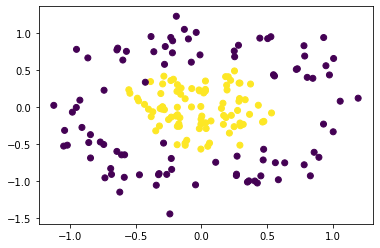

In [22]:
plt.scatter(X_test[:,0], X_test[:,1], c=preds_classes.detach().numpy())

The model seems to be able to classify the test set accurately. If you remember the first figure, the yellow circles were in the center and the purple circles were on the edges. The model has learned that pattern. The train and test accuracy reported below support the conclusion that the model has learned this dataset

In [23]:
print(f"X_train Accuracy: {(((torch.max(model(X_train), 1)[1] == y_train).sum())/len(y_train)).item() * 100}%")
print(f"X_test Accuracy: {(((preds_classes == y_test).sum())/len(y_test)).item() * 100}%")

X_train Accuracy: 98.7500011920929%
X_test Accuracy: 97.77777791023254%


## View the decision Boundary

The following is a function to view the decision boundary. This function generates thousands of points and feeds them to the network. It creates a precise decision boundary based on the model's predictions.

In [24]:
def boundary(X, ax): # determine boundary between different colored dots
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    spacing = min(x_max - x_min, y_max - y_min) / 100
    XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),np.arange(y_min, y_max, spacing))
    data = np.hstack((XX.ravel().reshape(-1,1),YY.ravel().reshape(-1,1)))
    data_t = torch.FloatTensor(data)
    db_prob = model(data_t)
    _, clf = torch.max(db_prob, 1)
    Z = clf.reshape(XX.shape)
    return(ax.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.6))

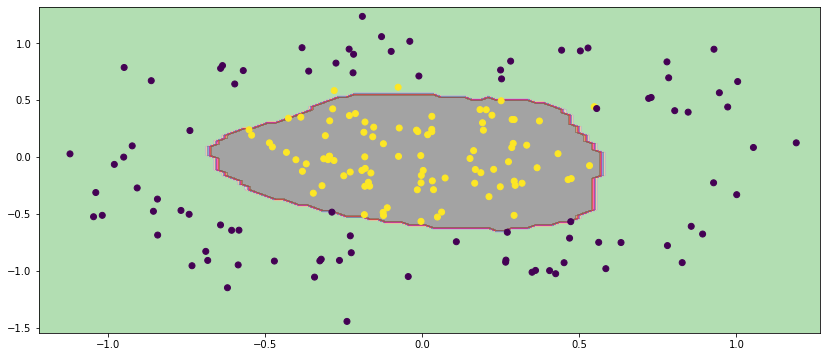

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))
_ = boundary(X_test, ax)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,cmap='viridis')

That's it for this tutorial.